MOTIVATION

Detailed simulation of qubit-cavity coupling with two-photon sideband transitions to verify the simplified simulation of the cQED atomic beam experiment.

NOTES

- 1 ns unit for time
- Conventions:
  - [qubit, resonator ]
  - Qubit: blue
  - Resonator: red

VALUES
- Red sideband transitions:
    - wq = 6.5, wc = 4 : wsb ~ 1.273 * 2 * pi
    - wq = 4, wc = 6.5 : wsb ~ 1.253 * 2 * pi

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plots
import os
import shutil
import time
from datetime import datetime
from glob import glob
from copy import copy
from supports import *
from automated import automated
from qutip import *
from scipy.special import erf
from scipy.signal import argrelextrema

options = Options()
options.store_states=True

In [2]:
print(drive)

<function drive at 0x7f7b934c8488>


In [4]:
Nq = 2   # number of levels in qubit
Nc = 10  # number of levels in resonator 1

wq = 6.5 *2*pi    # qubit frequency
wc = 4 *2*pi    # resonator 1 frequency
delta = wq - wc  # detuning
Ec = 0.16 *2*pi  # anharmonicity (charging energy)
g = 0.2 *2*pi  # drive frequency resonator 1, coupling between qubit and resonator 1
chi = 30e-6 *2*pi  # photon number-dependent frequency shift of qubit

Omega = 0.3*2*pi  # amplitude of sideband transitions
wd = 1.273*2*pi #1/4*(3*wq - wc - sqrt((wq + wc)**2 - 4*Omega**2))  # pump drive frequency

wq_mod = wq + Omega**2/(2*(wq-wd)) + Omega**2/(2*(wq+wd))

In [5]:
t0 = 0         # start of simulation
t1 = t0 + 0   # start of drive
t2 = t1 + 1000  # end of drive
t3 = t2 + 0   # end of simulation
tg = 10        # length of gaussian rise and fall

smooth = True  # whether or not to rise and fall with gaussian
Q = 4          # number of std's in gaussian rise and fall

Np = 100*int(t3)     # number of discrete time steps for which to store the output
print("timestep =", 1e3*np.round(t3/Np, 5), "ps")

timestep = 10.0 ps


In [6]:
# Qubit operators
b = tensor(destroy(Nq), qeye(Nc))
nq = b.dag()*b

# Cavity operators
a = tensor(qeye(Nq), destroy(Nc))
nc = a.dag()*a

# Jaynes-Cummings Hamiltonian
Hjc = wq*nq + wc*nc - Ec/2*b.dag()*b.dag()*b*b - chi*nq*nc
Hc = g*(a*b + a*b.dag() + b*a.dag() + a.dag()*b.dag())

# Sideband transitions
Hd = Omega*(b + b.dag())

# Hamiltonian arguments
H_args = {'t0' : t0, 't1' : t1, 't2' : t2,
          't3' : t3, 'tg' : tg, 'Q'  : Q,
          'smooth' : smooth, 'wd' : wd}

# Expectation operators
e_ops = [nq, nc]

In [7]:
H = [Hjc, [Hc, drive_nonosc], [Hd, drive]]  # complete Hamiltonian
psi0 = tensor(psi_pi(Nq), basis(Nc, 0))  # initial state

# Select these options for bdf method
# options.method = 'bdf'
# options.rtol = 1e-10
# options.atol = 1e-10

# Select these options for adams method
options.nsteps = 1000
options.rtol = 1e-12
options.atol = 1e-12
options.max_step = 0

Np_per_batch = Np/40  # number of time points per batch

In [6]:
batches = create_batches(0, t3, Np, Np_per_batch)

# Remove existing progress folder
for folder in glob("/home/student/thesis/prog_*"):
    shutil.rmtree(folder)

# Make new progress folder
now = datetime.now()
nowstr = now.strftime("%y_%m_%d_%H_%M_%S")
folder = "/home/student/thesis/prog_" + nowstr
os.makedirs(folder)

# Calculate!
for num, tlist in enumerate(batches):
    print(num+1, "/", len(batches), ":", int(np.round(100*(num+1)/len(batches))), "%")
    result = mesolve(H, psi0, tlist, [], e_ops=e_ops, args=H_args, options=options)
    saveprog(result, num, folder)
    psi0 = copy(result.states[-1])
    del result
end_calc = datetime.now()
print("Evolution completed in {} s".format((end_calc - now).total_seconds()))

1 / 40 : 2 %
2 / 40 : 5 %
3 / 40 : 8 %
4 / 40 : 10 %
5 / 40 : 12 %
6 / 40 : 15 %
7 / 40 : 18 %
8 / 40 : 20 %
9 / 40 : 22 %
10 / 40 : 25 %
11 / 40 : 28 %
12 / 40 : 30 %
13 / 40 : 32 %
14 / 40 : 35 %
15 / 40 : 38 %
16 / 40 : 40 %
17 / 40 : 42 %
18 / 40 : 45 %
19 / 40 : 48 %
20 / 40 : 50 %
21 / 40 : 52 %
22 / 40 : 55 %
23 / 40 : 58 %
24 / 40 : 60 %
25 / 40 : 62 %
26 / 40 : 65 %
27 / 40 : 68 %
28 / 40 : 70 %
29 / 40 : 72 %
30 / 40 : 75 %
31 / 40 : 78 %
32 / 40 : 80 %
33 / 40 : 82 %
34 / 40 : 85 %
35 / 40 : 88 %
36 / 40 : 90 %
37 / 40 : 92 %
38 / 40 : 95 %
39 / 40 : 98 %
40 / 40 : 100 %
Evolution completed in 317.791418 s


In [7]:
srcfolder = folder # "/home/student/thesis/"
selection = All # (0, t3)
reduction = 5

combine_batches(srcfolder, selection, reduction,
                quants=['times', 'expect'], return_data=False)
end_comb = datetime.now()
print("Batches combined    in {} s".format((end_comb - end_calc).total_seconds()))

Batches combined    in 3.295595 s


In [8]:
tfile = open(srcfolder + "/times.pkl", 'rb')
tdata = pickle.load(tfile)
times = tdata['data']
tfile.close()
del tdata

# sfile = open(srcfolder + "/states.pkl", 'rb')
# sdata = pickle.load(sfile)
# states = sdata['data']
# sfile.close()
# del sdata

efile = open(srcfolder + "/expect.pkl", 'rb')
edata = pickle.load(efile)
expect = edata['data']
efile.close()
del edata

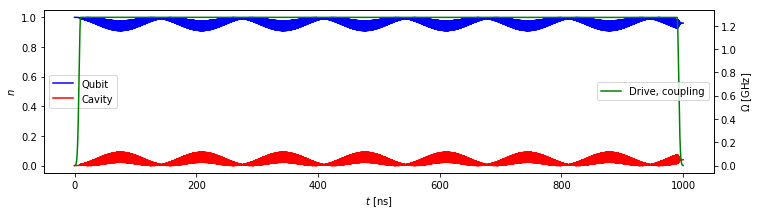

In [11]:
fig, ax1 = plt.subplots(figsize=[12,3])
ax1.plot(times, expect[0], color='b', label='Qubit')
ax1.plot(times, expect[1], color='r', label='Cavity')
ax1.set_xlabel("$t$ [ns]")
ax1.set_ylabel("$n$")
ax1.tick_params(axis='y')
ax1.legend(loc='center left')

# ax1.set_xlim([10, 70])

drive = wd/(2*pi)*drive_nonosc(times, H_args)
ax2 = ax1.twinx()
ax2.plot(times, drive, color='g', label='Drive, coupling')
ax2.set_ylabel('$\Omega$ [GHz]')
ax2.tick_params(axis='y')
ax2.legend(loc='center right')

plt.show()

In [2]:
wds = np.linspace(1.25*2*pi, 1.3*2*pi, 21)
for wd in wds:
    automated(wd)

UnboundLocalError: local variable 'drive' referenced before assignment